In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load and prepare data
df = pd.read_csv('data/data_monitoreo_contaminantes_filtrado.csv')
df['FECHA'] = pd.to_datetime(df['FECHA'])

In [3]:
# Enhanced feature engineering
df['DIA_SEMANA'] = df['FECHA'].dt.dayofweek
df['MES'] = df['FECHA'].dt.month
df['AÑO'] = df['FECHA'].dt.year
df['ES_FIN_DE_SEMANA'] = df['DIA_SEMANA'].isin([5, 6]).astype(int)
df['HORA_SIN'] = np.sin(2 * np.pi * df['HORA']/24)  # Cyclical encoding for hour
df['HORA_COS'] = np.cos(2 * np.pi * df['HORA']/24)
df['MES_SIN'] = np.sin(2 * np.pi * df['MES']/12)    # Cyclical encoding for month
df['MES_COS'] = np.cos(2 * np.pi * df['MES']/12)

# Aggregate data with new features
df_agregado = df.groupby(['ESTACION', 'DISTRITO', 'AÑO', 'MES', 'DIA_SEMANA', 'ES_FIN_DE_SEMANA', 
                         'HORA', 'HORA_SIN', 'HORA_COS', 'MES_SIN', 'MES_COS'])['PM10'].agg(['mean']).reset_index()
df_agregado.columns = ['ESTACION', 'DISTRITO', 'AÑO', 'MES', 'DIA_SEMANA', 'ES_FIN_DE_SEMANA', 
                      'HORA', 'HORA_SIN', 'HORA_COS', 'MES_SIN', 'MES_COS', 'PM10_MEAN']

# Extended feature selection
features = ['ESTACION', 'DISTRITO', 'HORA', 'DIA_SEMANA', 'MES', 'AÑO', 'ES_FIN_DE_SEMANA']
X = df_agregado[features]
y = df_agregado['PM10_MEAN']

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Enhanced preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), ['ESTACION', 'DISTRITO']),
        ('num', StandardScaler(), ['HORA', 'DIA_SEMANA', 'MES', 'AÑO', 'ES_FIN_DE_SEMANA'])
    ])

In [5]:
def train_and_evaluate(rf_params, gb_params, meta_params):
    rf_model = RandomForestRegressor(**rf_params, random_state=42)
    gb_model = GradientBoostingRegressor(**gb_params, random_state=42)
    meta_model = RandomForestRegressor(**meta_params, random_state=42)
    
    stack = StackingRegressor(
        estimators=[('rf', rf_model), ('gb', gb_model)],
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1
    )
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('stacking', stack)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nParameters:")
    print(f"RF: {rf_params}")
    print(f"GB: {gb_params}")
    print(f"Meta: {meta_params}")
    print(f"Metrics - MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")
    
    return r2, pipeline

In [6]:
# Enhanced parameter combinations
parameter_sets = [ 
    # Aggressive GB with support
    {
        'rf': {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 2},
        'gb': {'n_estimators': 400, 'learning_rate': 0.2, 'max_depth': 10, 'subsample': 0.8},
        'meta': {'n_estimators': 100, 'max_depth': 15}
    } 
]

# Test all parameter combinations
best_r2 = 0
best_pipeline = None
best_params = None

In [7]:
print("Starting enhanced parameter optimization...")
for i, params in enumerate(parameter_sets):
    print(f"\nTesting combination {i+1}/{len(parameter_sets)}")
    r2, pipeline = train_and_evaluate(params['rf'], params['gb'], params['meta'])
    
    if r2 > best_r2:
        best_r2 = r2
        best_pipeline = pipeline
        best_params = params
        print(f"New best model found! R² = {r2:.4f}")

print("\nBest parameters found:")
print(f"Random Forest: {best_params['rf']}")
print(f"Gradient Boosting: {best_params['gb']}")
print(f"Meta-model: {best_params['meta']}")
print(f"Best R² Score: {best_r2:.4f}")

Starting enhanced parameter optimization...

Testing combination 1/1


c:\Users\marli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Parameters:
RF: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 2}
GB: {'n_estimators': 400, 'learning_rate': 0.2, 'max_depth': 10, 'subsample': 0.8}
Meta: {'n_estimators': 100, 'max_depth': 15}
Metrics - MSE: 57.03, MAE: 4.40, R²: 0.9177
New best model found! R² = 0.9177

Best parameters found:
Random Forest: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 2}
Gradient Boosting: {'n_estimators': 400, 'learning_rate': 0.2, 'max_depth': 10, 'subsample': 0.8}
Meta-model: {'n_estimators': 100, 'max_depth': 15}
Best R² Score: 0.9177


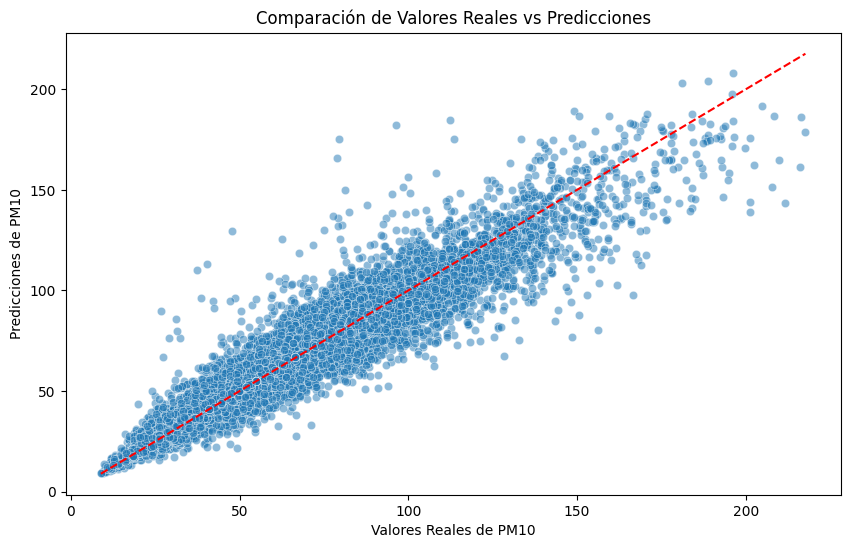

In [8]:
# Predicciones
y_pred = pipeline.predict(X_test)

# Visualización de error con Gráfica de Dispersión
errores = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores Reales de PM10")
plt.ylabel("Predicciones de PM10")
plt.title("Comparación de Valores Reales vs Predicciones")
plt.show()

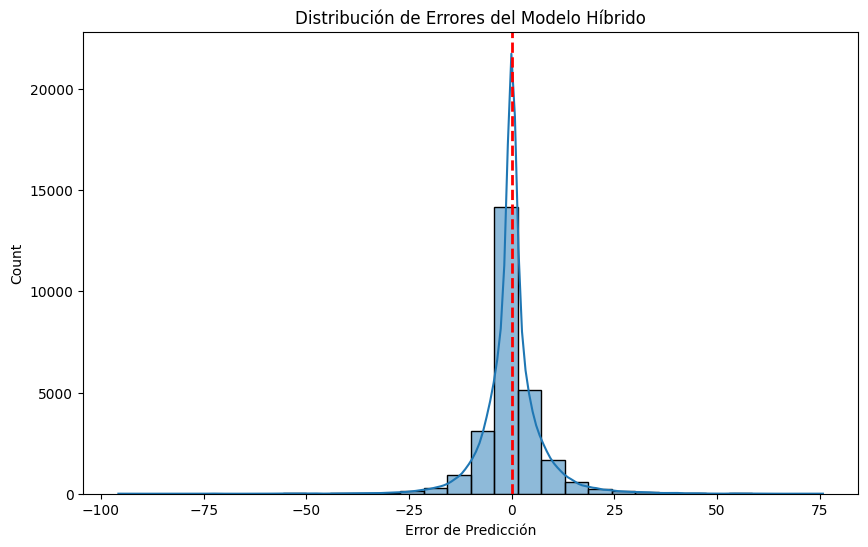

In [9]:
# Histograma del error
plt.figure(figsize=(10, 6))
sns.histplot(errores, bins=30, kde=True)
plt.axvline(errores.mean(), color='red', linestyle='dashed', linewidth=2)
plt.title("Distribución de Errores del Modelo Híbrido")
plt.xlabel("Error de Predicción")
plt.show()

In [10]:
# Save best model
joblib.dump(best_pipeline, f'..\prediccion_reforestacion\modelo\modelo_hibrido_{best_r2:.4f}.pkl')
print("Best model saved!")

Best model saved!
